# Notebook de Estudo do Seq2Seq com Atenção

Do enunciado do EP:

> O primeiro passo do trabalho consiste na implementação de uma arquitetura encoder-decoder (sequence-to-sequence) usando uma rede bidirecional LSTM (ou GRU, a escolha) como Encoder, uma rede LSTM (ou GRU) como
Decoder, e uma camada de atenção relacionando os estados intermediários da entrada com a saída. 
O número de camadas da sua rede fica a sua escolha.

In [1]:
!nvidia-smi

Mon Dec 21 12:39:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   35C    P0    35W / 250W |      0MiB / 16160MiB |      4%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import sys
sys.path.append('..')

In [3]:
from code_utils.metrics import decode_text, generate_sequences, report_linguistic_metrics
from code_utils.models.bilstm.training import define_tokenization_layers, define_full_model
from code_utils.models.bilstm.inference import encoder_inference_model, decoder_inference_model
from code_utils.preprocessing.data_preprocessing import process_data

[nltk_data] Downloading package wordnet to
[nltk_data]     /var/fasttmp/abarbosa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (AdditiveAttention, Attention,
                                     Bidirectional, Dense, Embedding, Input, LSTM)
from tensorflow.keras.utils import plot_model

import pandas as pd

In [5]:
DATA_PATH = "../data/b2w-10k.csv"
SEP=','
REVIEW_TITLE = "review_title"
REVIEW_TEXT = "review_text"
tf.random.set_seed(42)
np.random.seed(42)

In [6]:
(
    encoder_train,
    encoder_test,
    decoder_train,
    decoder_test,
    decoder_label_train,
    decoder_label_test,
) = process_data(DATA_PATH, REVIEW_TEXT, REVIEW_TITLE, SEP)

In [7]:
enc_sequence = [len(txt[0].split()) for txt in encoder_train]
np.quantile(enc_sequence, q=[i/10 for i in range(1, 10)]+[.99])

array([  9.,  10.,  12.,  13.,  15.,  18.,  23.,  30.,  45., 117.])

In [8]:
dec_sequence = [len(txt[0].split()) for txt in decoder_train]
np.quantile(dec_sequence, q=[i/10 for i in range(1, 10)]+[.99])

array([ 3.  ,  3.  ,  4.  ,  4.  ,  4.  ,  5.  ,  5.  ,  6.  ,  8.  ,
       14.02])

In [9]:
ENCODER_SEQ_LENGTH = 65
DECODER_SEQ_LENGTH = 10

In [10]:
(
    tokenizer_layer_encoder,
    tokenizer_layer_decoder,
    tokenizer_layer_decoder_inference,
) = define_tokenization_layers(
    encoder_train, decoder_train, ENCODER_SEQ_LENGTH, DECODER_SEQ_LENGTH
)

In [11]:
VOCAB_SIZE_encoder = len(tokenizer_layer_encoder.get_vocabulary()) + 2
VOCAB_SIZE_decoder = len(tokenizer_layer_decoder.get_vocabulary()) + 2
BATCH_SIZE = 256
EPOCHS=50
EMBED_DIM = 64  # tamanho do Embedding de cada token
LEARNING_RATE=0.001

In [12]:
# Encoder definition
input_text_encoder = Input(shape=(1,), dtype=tf.string, name="input_text")
emb_enc_layer = Embedding(VOCAB_SIZE_encoder, EMBED_DIM, name="encoder_embedding")
encoder_lstm = Bidirectional(
    LSTM(EMBED_DIM, return_sequences=True, return_state=True, name="encoder_rnn")
)

In [13]:
#Decoder definition 
input_text_decoder = Input(shape=(None,),dtype=tf.string, name="decoder_input")
emb_dec_layer = Embedding(VOCAB_SIZE_decoder, EMBED_DIM,name="decoder_embedding")
decoder_lstm = LSTM(EMBED_DIM*2, return_sequences=True, return_state=True, name="decoder_rnn")
attention_layer = Attention(name="attention", causal=True)
decoder_dense =  Dense(VOCAB_SIZE_decoder, activation='softmax', name="dense_layer")

In [14]:
## Preprocessing step
tokenized_input = tokenizer_layer_encoder(input_text_encoder)  # Tokenizer
tokenized_decoder = tokenizer_layer_decoder(input_text_decoder)
#embedding layer
enc_emb =  emb_enc_layer(tokenized_input)
dec_emb = emb_dec_layer(tokenized_decoder)

In [15]:
model =  define_full_model(input_text_encoder,enc_emb, encoder_lstm,
                       input_text_decoder, dec_emb, decoder_lstm,
                       attention_layer, decoder_dense
                      )

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
encoder_vectorizer (TextVectori (None, 65)           0           input_text[0][0]                 
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, 65, 64)       848448      encoder_vectorizer[0][0]         
______________________________________________________________________________________________

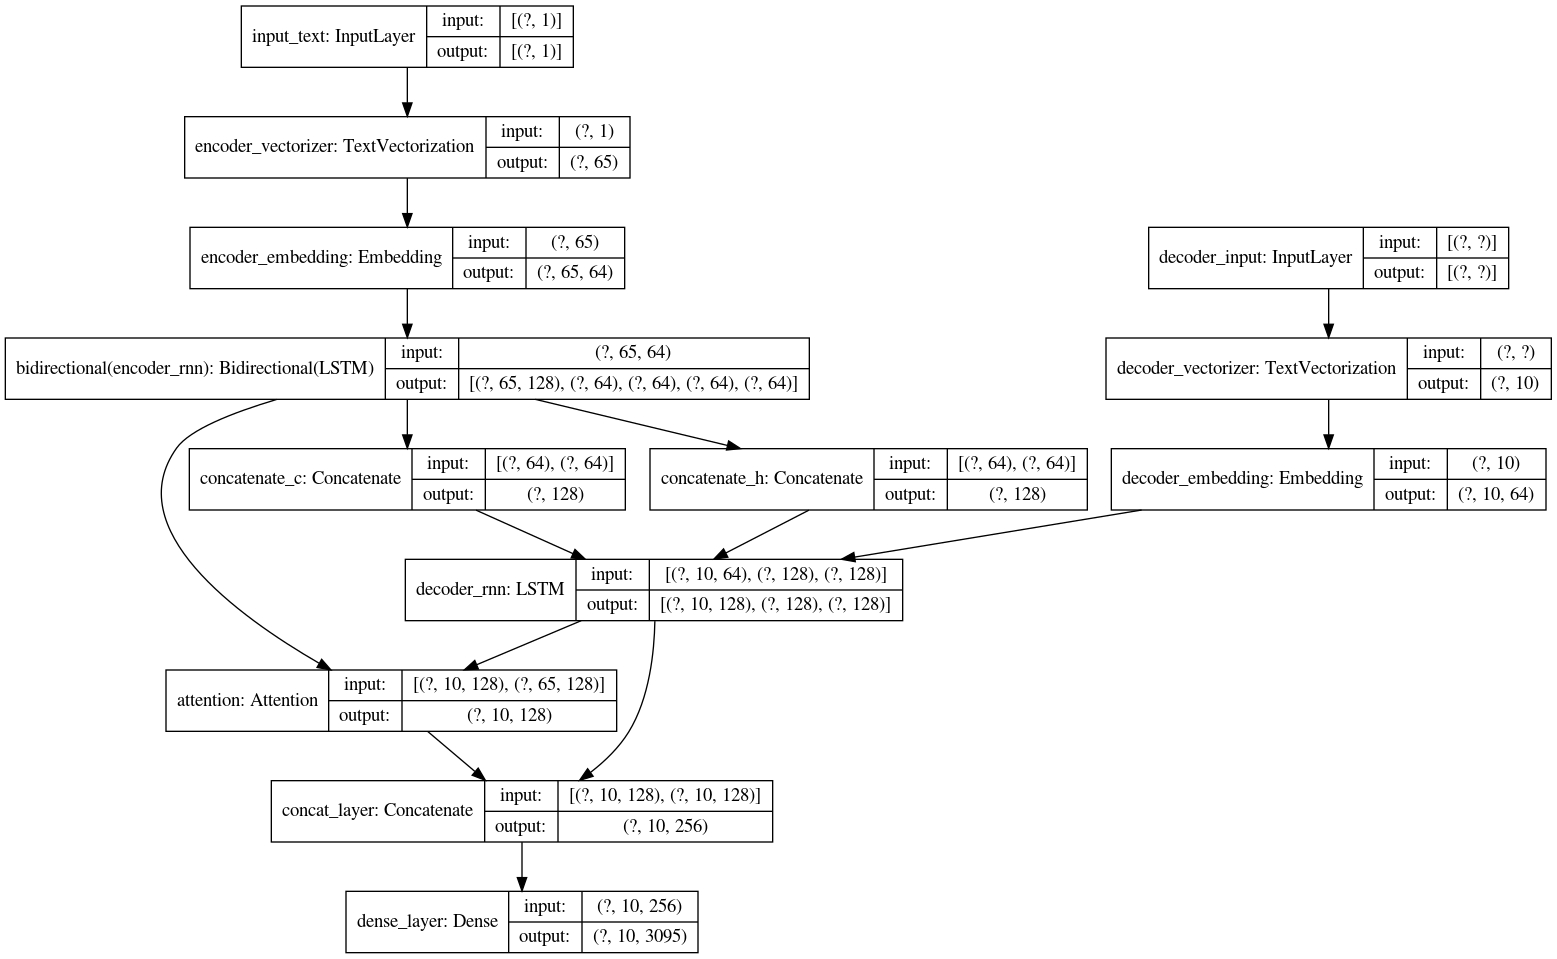

In [17]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [18]:
opt = tf.keras.optimizers.Adam(LEARNING_RATE)
model.compile(
    optimizer=opt,
    loss={"dense_layer": "sparse_categorical_crossentropy"},
    metrics={"dense_layer": "accuracy"},
)

In [19]:
print(f"Forma do Dataset de Treinamento: {encoder_train.shape}")

Forma do Dataset de Treinamento: (7999, 1)


In [20]:
my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)]

history = model.fit(
    [encoder_train, decoder_train],
    tokenizer_layer_decoder(decoder_label_train),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=my_callbacks,
    validation_split=0.1
)

Epoch 1/50
29/29 [==============================] - 5s 171ms/step - loss: 6.1605 - accuracy: 0.5658 - val_loss: 2.4593 - val_accuracy: 0.5941
Epoch 2/50
29/29 [==============================] - 1s 48ms/step - loss: 2.2472 - accuracy: 0.6240 - val_loss: 2.3000 - val_accuracy: 0.6274
Epoch 3/50
29/29 [==============================] - 1s 41ms/step - loss: 2.1257 - accuracy: 0.6444 - val_loss: 2.2483 - val_accuracy: 0.6304
Epoch 4/50
29/29 [==============================] - 1s 44ms/step - loss: 2.0673 - accuracy: 0.6460 - val_loss: 2.2086 - val_accuracy: 0.6294
Epoch 5/50
29/29 [==============================] - 1s 47ms/step - loss: 1.9794 - accuracy: 0.6677 - val_loss: 2.0945 - val_accuracy: 0.6766
Epoch 6/50
29/29 [==============================] - 1s 49ms/step - loss: 1.8499 - accuracy: 0.6974 - val_loss: 1.9762 - val_accuracy: 0.6921
Epoch 7/50
29/29 [==============================] - 1s 44ms/step - loss: 1.7625 - accuracy: 0.7075 - val_loss: 1.9240 - val_accuracy: 0.6990
Epoch 8/50
2

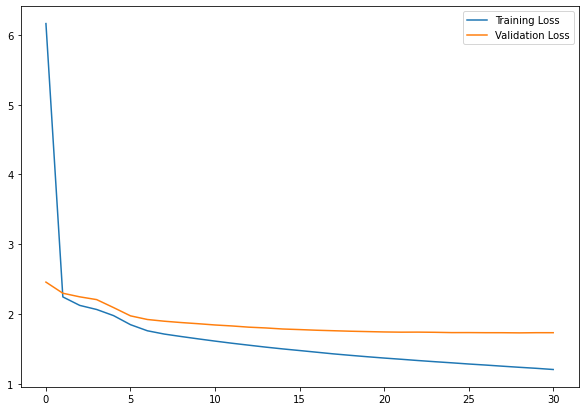

In [21]:
plt.figure(figsize=(10,7))
a, = plt.plot(history.history['loss'],label='Training Loss')
b, = plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend(handles=[a,b])
plt.show()

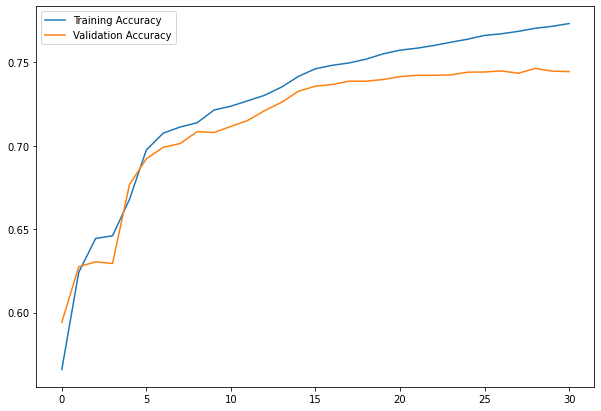

In [22]:
plt.figure(figsize=(10,7))
a, = plt.plot(history.history['accuracy'],label='Training Accuracy')
b, = plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.legend(handles=[a,b])
plt.show()

In [23]:
test_loss, test_acc = model.evaluate([encoder_test, decoder_test],
                                          tokenizer_layer_decoder(decoder_label_test),
                                          batch_size=128)

16/16 [==============================] - 0s 13ms/step - loss: 1.6714 - accuracy: 0.7505


In [24]:
tokenized_decoder_inference = tokenizer_layer_decoder_inference(input_text_decoder)
dec_emb_embedding_inference = emb_dec_layer(tokenized_decoder_inference)

In [25]:
encoder_inference = encoder_inference_model(input_text_encoder, encoder_lstm, enc_emb)

In [26]:
decoder_inference = decoder_inference_model(
    decoder_embedding=dec_emb_embedding_inference,
    target_text=input_text_decoder,
    latent_dim=EMBED_DIM,
    encoder_sequence_length=ENCODER_SEQ_LENGTH,
    decoder_lstm=decoder_lstm,
    attention_layer=attention_layer,
    decoder_dense=decoder_dense,
)

In [27]:
sentences = generate_sequences(
    encoder_test,
    decoder_label_test,
    100,
    encoder_inference,
    decoder_inference,
    DECODER_SEQ_LENGTH,
    tokenizer_layer_decoder_inference,
)

Gerando Predições: 100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


In [28]:
sentences.head()

,target_processed,predicted
1126,excelente aquisição. super recomendo!,gostei muito do produto
1459,bom produto - ótimo custo x benefício,gostei
860,bom produto,muito bom
1294,"gostei muito, super indico!",muito bom
1130,ótimo aparelho,gostei do produto


In [29]:
bleu_metric, nist_metric, meteor_metric = report_linguistic_metrics(sentences)

/var/fasttmp/abarbosa/.cache/pypoetry/virtualenvs/ep_3-_2D5rvl2-py3.7/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/var/fasttmp/abarbosa/.cache/pypoetry/virtualenvs/ep_3-_2D5rvl2-py3.7/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/var/fasttmp/abarbosa/.cache/pypoetry/virtualenvs/ep_3-_2D5rvl2-py3.7/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the B

In [30]:
pd.DataFrame([test_acc, bleu_metric, nist_metric, meteor_metric]).T.rename(columns={0:'accuracy',
                                                                                    1:'bleu score',
                                                                                    2:'nist score',
                                                                                    3:'meteor score'})

,accuracy,bleu score,nist score,meteor score
0,0.75055,1.446016e-231,0.291931,0.003846
